<a href="https://colab.research.google.com/github/AschHarwood/social_unrest/blob/main/social_unrest_timeseries_v4_10_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installs

In [ ]:
%pip install us

     |████████████████████████████████| 132 kB 10.0 MB/s 
  Created wheel for us: filename=us-2.0.2-py3-none-any.whl size=11942 sha256=84101b83888fd1bb4d7808cf4404de47a9be0a39aa25e0d6b7e6c200e6487a5c
  Stored in directory: /root/.cache/pip/wheels/ca/6b/11/cda9ea2438f721330a35c9a2c8e34b4aedcd34c89af48a4d00
  Created wheel for jellyfish: filename=jellyfish-0.6.1-cp37-cp37m-linux_x86_64.whl size=72168 sha256=ab561f6e16d923163cac2418b0a201204c7e480a7c26ba0af4df8dd634d45ff9
  Stored in directory: /root/.cache/pip/wheels/a1/99/51/7de469e37cd1b3c763c24394e1ebf1baa2d79e094bf346cf80
Successfully built us jellyfish


In [ ]:
%pip install tsfresh

In [ ]:
# %pip install boto3

In [ ]:
#%pip install swifter

In [ ]:
#%pip install gensim

In [ ]:
# %pip install pycaret[full]

In [ ]:
%pip install wandb

In [ ]:
import os
import boto3
session = boto3.session.Session()
client = session.client('s3',
                        region_name='nyc3',
                        endpoint_url='https://nyc3.digitaloceanspaces.com',
                        aws_access_key_id='O3SBKD6RCH7NKRY35CNQ',
                        aws_secret_access_key='MGXit8TU8yk9AXp1NUgp/MunqS3CTRbWH8oNGii1Ehs')

In [ ]:
client.download_file('politicalnews', 'political_violence/features/main_feature_sets/main_dataset_v2_9_13_21.feather', '/content/social_unrest_data/main_data_9_13.feather')

## Imports

In [608]:
# import wandb
# from wandb.keras import WandbCallback
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from pycaret.utils import enable_colab 
#enable_colab()
#%pip install tensorflow_hub
import tensorflow_hub as hub
import tensorflow as tf
import us
import plotly.express as px

# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [ ]:
wandb.login()

wandb: Currently logged in as: rhml (use `wandb login --relogin` to force relogin)


True

## Reading Data

In [ ]:
df = pd.read_feather('/content/social_unrest_data/main_data_9_13.feather')

In [ ]:
df = df[df.fips!='nan']

In [ ]:
df.protest_count.value_counts()

0.0    1500528
1.0       4779
0         1967
2.0        257
3.0         31
4.0          8
6.0          3
5.0          3
8.0          2
Name: protest_count, dtype: int64

## Preprocessing data

**Steps**

- fill gaps in dates on dataset (done for complete dataset, needs to be done for 
- split data into numeric, categorical, and text
- drop`ST_ABBR`, `index`

Target
- convert `protest_count` to binary

Date/categorical
- split date data in day, month, year
- `fips` to `int`
- label encode 
      'Governor Political Affiliation',
       'State Senate Majority Political Affiliation',
       'State House Majority Political Affiliation',
       'State Attorney General Political Affiliation',
       'State Insurance Commissioner Political Affiliation'

Text
- split off `reddit`, `articles`, `tweets`
- tokenize
- create word embeddings

Numeric

- convert to float


Steps

- Do datatype converstions
- create word embeddings for text
- reassemble dataset
- train_test_split
- RobustScaler
- PCA
- then to PYcaret or some other time series model


In [ ]:
#df.drop(['index', 'ST_ABBR'], axis=1, inplace=True)
df.protest_count = df.protest_count.astype(float)
def convert_to_classification(x):
  if x == 0.0:
    protest_class = 0
  else:
    protest_class = 1
  return protest_class
df['protest_class'] = df['protest_count'].apply(lambda x: convert_to_classification(x))
df.reset_index(inplace=True)
df[['fips', 'state_fips']] = df[['fips', 'state_fips']].astype(int)
df.date = pd.to_datetime(df.date)
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['day'] = df.date.dt.day
df.set_index('date', inplace=True)


In [ ]:
df.protest_class.value_counts()

0    1502495
1       5083
Name: protest_class, dtype: int64

In [ ]:
cat_dummies = pd.get_dummies(df.iloc[:,162:165])
cat_to_drop = df.iloc[:,162:167].columns
df.drop(cat_to_drop, axis=1, inplace=True)
df = pd.concat([df, cat_dummies], axis=1)

In [ ]:
df.reset_index(inplace=True)

## WandB Logging

In [ ]:
run = wandb.init(project='social_unrest')
main_df = wandb.Artifact('main_dataset', type='raw_data')
main_df.add_dir('/content/social_unrest_data')
run.log_artifact(main_df)

wandb: Currently logged in as: rhml (use `wandb login --relogin` to force relogin)
2021-10-25 20:56:26.292099: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


wandb: Adding directory to artifact (/content/social_unrest_data)... Done. 19.0s


In [ ]:
main_df = wandb.Artifact('main_dataset', type='raw_data')
main_df.add_file('/content/social_unrest_data/main_data_9_13.feather')
run.log_artifact(main_df)

## Whole Dataset preprocessing

In [ ]:
df.articles

0          None
1          None
2          None
3          None
4          None
           ... 
1520268    None
1520269    None
1520270    None
1520271    None
1520272    None
Name: articles, Length: 1507578, dtype: object

In [ ]:
embed = hub.load("https://tfhub.dev/google/nnlm-en-dim50/2")
ca = df.copy()
# date_range = pd.date_range(start='2020-01-07', end='2021-05-24')
# missing_dates = date_range.difference(ca.index)
# missing_dates_dataframe = pd.DataFrame(missing_dates)
# missing_dates_dataframe.rename(columns={0: 'date'}, inplace=True)
# #ca.drop(['level_0', 'index'], axis=1, inplace=True)
# ca = pd.concat([ca, missing_dates_dataframe])
# ca.sort_values(by='date', inplace=True)
# ca.date = pd.to_datetime(ca.date)
# ca['year'] = ca.date.dt.year
# ca['month'] = ca.date.dt.month
# ca['day'] = ca.date.dt.day
# ca[['tweets', 'reddit', 'articles']].fillna(value='None', inplace=True)
# ca.fillna(method='pad', inplace=True)
for col in ['tweets', 'reddit', 'articles']:
  embeddings = embed(ca[col])
  embed_array = np.array(embeddings)
  embed_dataframe = pd.DataFrame(embed_array)
  embed_dataframe['vector_mean'] = embed_dataframe.mean(axis=1)
  embed_dataframe.reset_index(inplace=True)
  ca.reset_index(inplace=True,drop=True)
  ca = pd.concat([ca, embed_dataframe], axis=1)


In [ ]:
ca.drop(ca.iloc[:, [1, 175, 227, 279]], axis=1, inplace=True)

In [ ]:
ca.info(max_cols=500)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1507578 entries, 0 to 1507577
Data columns (total 326 columns):
 #   Column                                                  Non-Null Count    Dtype         
---  ------                                                  --------------    -----         
 0   date                                                    1507578 non-null  datetime64[ns]
 1   state_fips                                              1507578 non-null  int64         
 2   fips                                                    1507578 non-null  int64         
 3   cases_avg                                               1507578 non-null  object        
 4   cases_avg_per_100k                                      1507578 non-null  object        
 5   deaths_avg                                              1507578 non-null  object        
 6   deaths_avg_per_100k                                     1507578 non-null  object        
 7   cases                              

In [ ]:
# #ca.date = pd.to_datetime(ca.date)
# #ca.set_index('date', inplace=True)

# ca.fillna(method='pad', inplace=True)
# def convert_to_classification(x):
#   if x == 0.0:
#     protest_class = 0
#   else:
#     protest_class = 1
#   return protest_class
# ca.protest_count =  ca.protest_count.astype(float)
# ca['protest_class'] = ca.protest_count.apply(lambda x: convert_to_classification(x))



In [ ]:
ca.drop(['articles', 'reddit', 'tweets'], axis=1, inplace=True)

In [ ]:

#ca.drop(['articles', 'tweets', 'reddit'], axis=1, inplace=True)
float_cols = ca.loc[:, 'cases_avg': 'Rate_filled'].columns
ca[float_cols] = ca[float_cols].astype(float)
# ca[['state_fips', 'fips']] = ca[['state_fips', 'fips']].astype(int)
ca.drop('protest_count', axis=1, inplace=True)
del df

In [ ]:
ca.columns = ca.columns.astype(str)

In [ ]:
nums_cols = list(range(150))

In [ ]:
str_cols = [str(i) for i in nums_cols]

In [ ]:
name_cols = ca.iloc[:,:172].columns

In [ ]:
name_cols = list(name_cols)

In [ ]:
name_cols.extend(str_cols)

In [ ]:
ca.columns = name_cols

In [ ]:
ca.to_parquet('main_dataset_embeddings_10_26.parquet')

In [ ]:
ca.reset_index(inplace=True)

## Embeddings with CA data

In [ ]:
embed = hub.load("https://tfhub.dev/google/nnlm-en-dim50/2")

In [ ]:
ca = df[df.state_fips==6]
date_range = pd.date_range(start='2020-01-07', end='2021-05-24')
missing_dates = date_range.difference(ca.index)
missing_dates_dataframe = pd.DataFrame(missing_dates)
missing_dates_dataframe.rename(columns={0: 'date'}, inplace=True)
#ca.drop(['level_0', 'index'], axis=1, inplace=True)
ca = pd.concat([ca, missing_dates_dataframe])
ca.sort_values(by='date', inplace=True)
ca.date = pd.to_datetime(ca.date)
ca['year'] = ca.date.dt.year
ca['month'] = ca.date.dt.month
ca['day'] = ca.date.dt.day
ca[['tweets', 'reddit', 'articles']].fillna(value='None', inplace=True)
ca.fillna(method='pad', inplace=True)
for col in ['tweets', 'reddit', 'articles']:

  embeddings = embed(ca[col])
  embed_array = np.array(embeddings)
  embed_dataframe = pd.DataFrame(embed_array)
  embed_dataframe['vector_mean'] = embed_dataframe.mean(axis=1)
  embed_dataframe.reset_index(inplace=True)
  ca.reset_index(inplace=True)
  ca = pd.concat([ca, embed_dataframe], axis=1)
ca.date = pd.to_datetime(ca.date)
ca.set_index('date', inplace=True)
ca.drop(['level_0', 'index'], axis=1, inplace=True)
ca.fillna(method='pad', inplace=True)
def convert_to_classification(x):
  if x == 0.0:
    protest_class = 0
  else:
    protest_class = 1
  return protest_class
ca.protest_count =  ca.protest_count.astype(float)
ca['protest_class'] = ca.protest_count.apply(lambda x: convert_to_classification(x))


ca.drop(['articles', 'tweets', 'reddit'], axis=1, inplace=True)
float_cols = ca.loc[:, 'cases_avg': 'Rate_filled'].columns
ca[float_cols] = ca[float_cols].astype(float)
ca[['state_fips', 'fips']] = ca[['state_fips', 'fips']].astype(int)
ca.drop('protest_count', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
ca.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1507578 entries, 2020-01-07 to 2021-05-24
Columns: 223 entries, state_fips to vector_mean
dtypes: float32(51), float64(155), int64(6), uint8(11)
memory usage: 2.1 GB


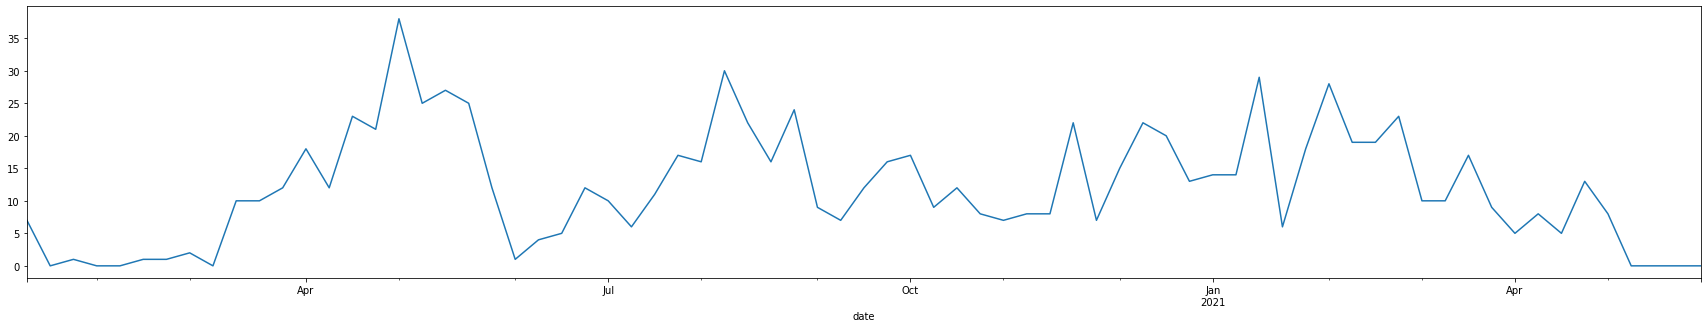

In [ ]:
ca.protest_class.resample('W').sum().plot(figsize=(30, 5))

## Pycaret on embedded california data

In [ ]:
from pycaret.classification import *

In [ ]:
s = setup(data=ca, target='protest_class', data_split_shuffle=False, fold_strategy='timeseries', fold=3, remove_multicollinearity=True, fix_imbalance=True)

,Description,Value
0,session_id,7239
1,Target,protest_class
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(28848, 223)"
5,Missing Values,False
6,Numeric Features,206
7,Categorical Features,16
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='protest_class',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeri...
                ('dummy', Dummify(target='protest_class')),
                ('fix_perfect', Remove_100(target='protest_class')),
       

In [ ]:
best = compare_models(sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9269,0.8080,0.3301,0.1936,0.2396,0.2041,0.2146,19.5500
nb,Naive Bayes,0.8289,0.7534,0.5585,0.1223,0.1993,0.1479,0.2012,0.4733
lda,Linear Discriminant Analysis,0.7859,0.7860,0.6109,0.1170,0.1927,0.1392,0.1982,0.3233
ada,Ada Boost Classifier,0.8928,0.7473,0.3523,0.1360,0.1898,0.1456,0.1674,3.8900
ridge,Ridge Classifier,0.7759,0.0000,0.5972,0.1162,0.1890,0.1354,0.1901,0.0967
lr,Logistic Regression,0.7372,0.7667,0.6384,0.1005,0.1683,0.1124,0.1735,3.5433
catboost,CatBoost Classifier,0.9577,0.8063,0.1058,0.3033,0.1548,0.1381,0.1596,11.6267
svm,SVM - Linear Kernel,0.5539,0.0000,0.7953,0.0913,0.1523,0.0946,0.1631,1.1100
lightgbm,Light Gradient Boosting Machine,0.9571,0.8116,0.0934,0.2570,0.1367,0.1199,0.1363,1.2667
xgboost,Extreme Gradient Boosting,0.9571,0.8116,0.0900,0.2535,0.1328,0.1160,0.1326,52.8767


INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=7239, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


In [ ]:
prediction_holdout = predict_model(best)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=7239, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False), probability_threshold=None, encoded_labels=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.928,0.8253,0.3622,0.1664,0.228,0.1957,0.2121


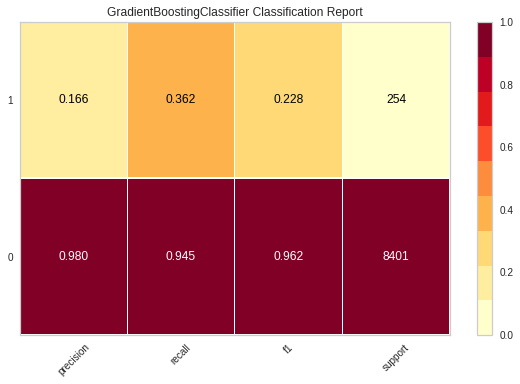

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(best, plot='class_report')

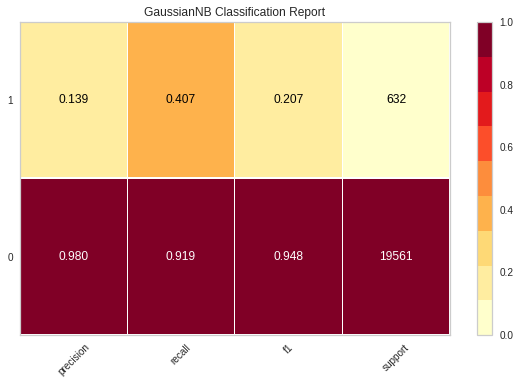

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(best, plot='class_report', use_train_data=True)

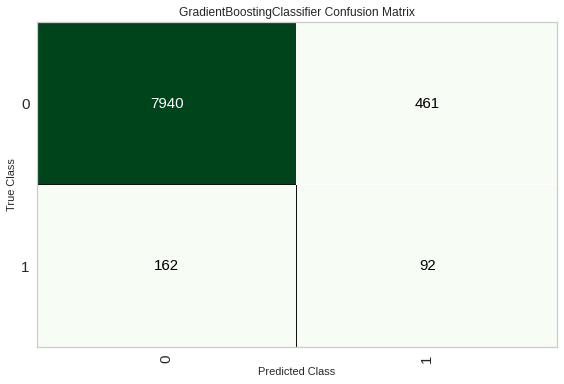

INFO:logs:Visual Rendered Successfully
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(best, plot='confusion_matrix')

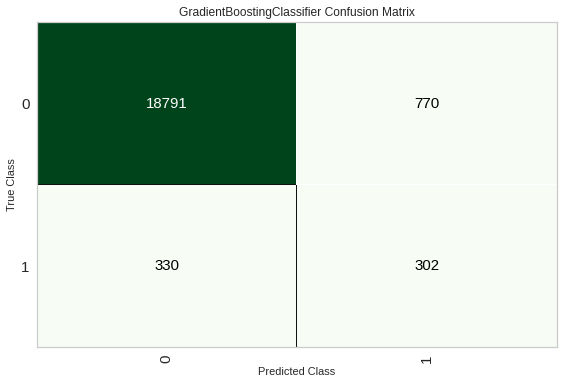

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(best, plot='confusion_matrix', use_train_data=True)

## Train_Test_Split


In [ ]:
ca.set_index('date', inplace=True)

In [ ]:

## train test split

split = int(len(ca[:500000])*.7)
train = ca[:split]
test = ca[split:]

In [ ]:
ca.protest_class.value_counts()

0    1502495
1       5083
Name: protest_class, dtype: int64

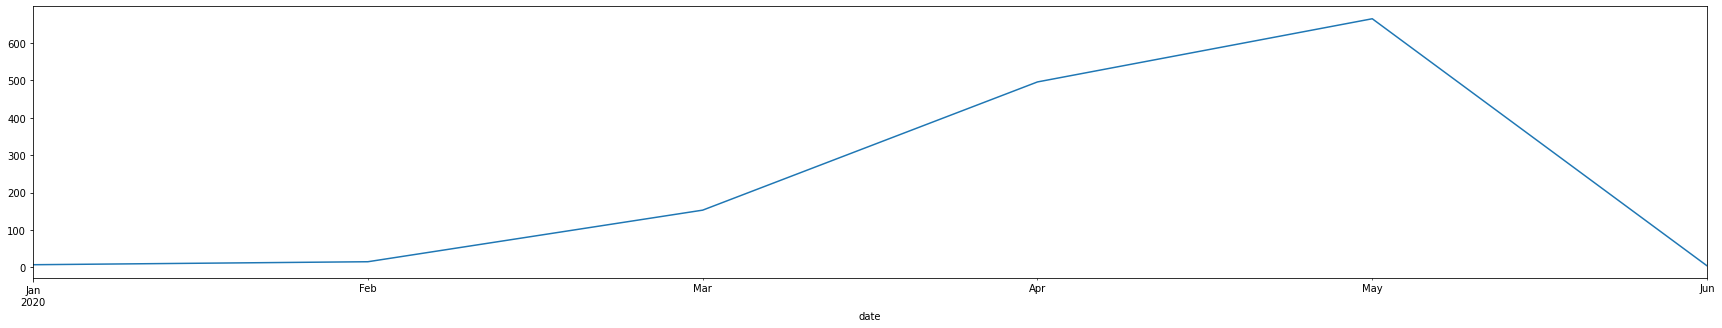

In [ ]:
train.protest_class.resample('M').sum().plot(figsize=(30, 5))

In [ ]:
test.protest_class.resample('M').sum().plot(figsize=(30, 5))

NameError: ignored

In [ ]:
x_train = train.drop('protest_class', axis=1)
y_train = train['protest_class']
x_test = test.drop('protest_class', axis=1)
y_test = test['protest_class']

# Keras Timeseries Alternative

https://github.com/SeanPLeary/time-series-h2o-automl-example/blob/master/lstm_example_with_multivariate_time_series.ipynb

In [ ]:

from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Model
from keras.layers import Input, Dense
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
from keras.layers import CuDNNLSTM

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
train = pd.DataFrame(x_train_scaled)
test = pd.DataFrame(x_test_scaled)
del x_train_scaled
del x_test_scaled
train.reset_index(inplace=True, drop=True)
y_train = pd.DataFrame(y_train).reset_index()
train = pd.concat([train, y_train], ignore_index=True, axis=1)
train.set_index(321, inplace=True)
test.reset_index(inplace=True, drop=True)
y_test = pd.DataFrame(y_test).reset_index()
test = pd.concat([test, y_test], ignore_index=True, axis=1)
test.set_index(321, inplace=True)

In [ ]:
def generator(dataframe, target_name, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=6):
    
    data = dataframe.values
    #data = data.astype(np.float32)
    target_indx = dataframe.columns.get_loc(target_name)
    
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][target_indx]
        yield samples, targets

In [ ]:
#use previous 450 samples to predict next target ('pollution') samples
lookback = 10 # window used for prediction
delay = 1 # predict target one step ahead
batch_size = 256

train_gen = generator(dataframe = train, 
                      target_name = 322, 
                      lookback = lookback,
                      delay = 1,
                      min_index = 0,
                      max_index = int(train.shape[0]*0.8),
                      step = 1,
                      shuffle = True,
                      batch_size = batch_size)

In [ ]:
valid_gen = generator(dataframe = train, 
                      target_name = 322, 
                      lookback = lookback,
                      delay = 1,
                      min_index = int(train.shape[0]*0.8),
                      max_index = None,
                      step = 1,
                      shuffle = False,
                      batch_size = batch_size)


In [ ]:
test_gen = generator(dataframe = test, 
                     target_name = 322, 
                     lookback = lookback,
                     delay = 1,
                     min_index = 0,
                     max_index = None,
                     step = 1,
                     shuffle = False,
                     batch_size = batch_size)

In [ ]:
x, y = next(test_gen)

In [ ]:
x[0].shape

(10, 322)

In [ ]:
# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = int((train.shape[0]*.1 - lookback) // batch_size)
print('validation_steps = ', val_steps)
# This is how many steps to draw from `train_gen`
# in order to see the whole train set:
train_steps = int((train.shape[0]*.9 - lookback) // batch_size)
print('train_steps = ', train_steps)
# This is how many steps to draw from `train_gen`
# in order to see the whole train set:
test_steps = int((test.shape[0] - lookback) // batch_size)
print('test_steps = ', test_steps)

validation_steps =  136
train_steps =  1230
test_steps =  4521


In [ ]:

model = Sequential()
# model.add(LSTM(50,
#                activation='relu',
#                return_sequences=True,
#                stateful=False,
#                input_shape=(None, train.shape[1])))
# model.add(LSTM(50,
#              activation='relu',
#              return_sequences=False,
#              stateful=False))

model.add(CuDNNLSTM(512,
               return_sequences=True,
               stateful=False,
               input_shape=(None, train.shape[1])))
model.add(CuDNNLSTM(250,
               return_sequences=True,
               stateful=False))
model.add(CuDNNLSTM(125,
               return_sequences=True,
               stateful=False))
model.add(CuDNNLSTM(62,
               return_sequences=True,
               stateful=False))
model.add(CuDNNLSTM(30,
               return_sequences=True,
               stateful=False))
model.add(CuDNNLSTM(15,
             return_sequences=False,
             stateful=False))
model.add(Dropout(0.4))

model.add(Dense(1, activation='sigmoid'))

In [ ]:

callbacks = [EarlyStopping(monitor='val_loss', min_delta = 0, patience=4),ModelCheckpoint(filepath='lstm_model.h5', monitor='val_loss', save_best_only=True)]

model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
history = model.fit(train_gen, steps_per_epoch=train_steps, epochs=5, shuffle=False, validation_data=valid_gen,validation_steps=50)

Epoch 1/5
1230/1230 [==============================] - 26s 19ms/step - loss: 0.0034 - accuracy: 0.9966 - val_loss: 0.0049 - val_accuracy: 0.9951
Epoch 2/5
1230/1230 [==============================] - 23s 18ms/step - loss: 0.0034 - accuracy: 0.9966 - val_loss: 0.0036 - val_accuracy: 0.9964
Epoch 3/5
1230/1230 [==============================] - 23s 19ms/step - loss: 0.0034 - accuracy: 0.9966 - val_loss: 0.0039 - val_accuracy: 0.9961
Epoch 4/5
1230/1230 [==============================] - 23s 19ms/step - loss: 0.0036 - accuracy: 0.9964 - val_loss: 0.0064 - val_accuracy: 0.9936
Epoch 5/5
1230/1230 [==============================] - 23s 19ms/step - loss: 0.0034 - accuracy: 0.9966 - val_loss: 0.0080 - val_accuracy: 0.9920


In [ ]:
model.evaluate(test_gen)
#y_pred = model.predict(test_gen,batch_size=256, verbose=1, workers=-1, use_multiprocessing=True)


  68570/Unknown - 533s 8ms/step - loss: 0.1852 - accuracy: 0.7564

KeyboardInterrupt: ignored

In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
test[322].value_counts()

0    451239
1      1035
Name: 322, dtype: int64

In [ ]:
y_truth.sum()

0.0

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_truth, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       256

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



## Keras TimeSeries

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
past = 10
future = 1
learning_rate = 0.001
batch_size = 256
epochs = 10

In [ ]:
start = past + future
end = start + train_split

In [ ]:
end

582527675

## AutoKeras

In [ ]:
predict_from = 1
predict_until = 10
lookback = 3
clf = ak.TimeseriesForecaster(
    lookback=lookback,
    predict_from=predict_from,
    predict_until=predict_until,
    max_trials=1,
    objective="val_loss",
    tuner='random'
)

In [ ]:
clf.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    batch_size=32,
    epochs=10,
)


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
timeseries_bloc...|True              |?                 
timeseries_bloc...|lstm              |?                 
timeseries_bloc...|3                 |?                 
regression_head...|0.25              |?                 
optimizer         |adam              |?                 
learning_rate     |0.01              |?                 

Epoch 1/10


UnknownError: ignored

### Splitting data

In [ ]:
tweets = df.tweets
reddit = df.reddit
articles = df.articles

In [ ]:
df.set_index('date', inplace=True)

In [ ]:
df.drop(['tweets', 'reddit', 'articles'], axis=1, inplace=True)

In [ ]:
float_cols = df.loc[:,'cases_avg': 'Rate_filled' ].columns

In [ ]:
df[float_cols] = df[float_cols].astype(float)

In [ ]:
df['tweets'] = tweets
df['reddit'] = reddit
df['articles'] = articles

In [ ]:
df.info(max_cols=500)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1507578 entries, 2020-01-07 to 2021-05-24
Data columns (total 177 columns):
 #   Column                                                  Non-Null Count    Dtype  
---  ------                                                  --------------    -----  
 0   index                                                   1507578 non-null  int64  
 1   state_fips                                              1507578 non-null  int64  
 2   fips                                                    1507578 non-null  int64  
 3   cases_avg                                               1507578 non-null  float64
 4   cases_avg_per_100k                                      1507578 non-null  float64
 5   deaths_avg                                              1507578 non-null  float64
 6   deaths_avg_per_100k                                     1507578 non-null  float64
 7   cases                                                   1507578 non-null  float64
 

In [ ]:
ca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28344 entries, 0 to 28343
Columns: 1506 entries, level_0 to State Senate Majority Political Affiliation_Unknown
dtypes: datetime64[ns](1), int64(8), object(159), uint8(1338)
memory usage: 72.5+ MB


In [ ]:
ca_embedded = pd.concat([ca, embed_dataframe], axis=1)

In [ ]:
ca_embedded.drop(['level_0', 'index', ''])

In [ ]:
ca_embedded

,level_0,date,index,state_fips,fips,cases_avg,cases_avg_per_100k,deaths_avg,deaths_avg_per_100k,cases,deaths,protest_count,Mobility_score,info_tweets,info_tweets_T,info_tweets_RE,info_tweets_RT,info_tweets_local,info_tweets_verified,info_tweets_unverified,info_fact_reliable,info_fact_unreliable,info_fact_unknown,info_fact_unreliable_fraction,info_fact_shadow,info_fact_missing,info_fact_science,info_fact_msm,info_fact_satire,info_fact_clickbait,info_fact_political,info_fact_fake,info_fact_conspiracy,info_iri,info_iri_T,info_iri_RE,info_iri_RT,info_dyn_iri,info_dyn_iri_RE,info_dyn_iri_RT,...,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,vector_mean
0,0,2020-01-07,0,6,6067,0.0,0.0,0.0,0.0,0.0,0.0,1.0,136.7974131911512,54427.0,12407.0,1770.0,40250.0,45957.0,2614.0,51813.0,9121.0,4737.0,5717.0,0.3418,4729.0,0.0,814.0,8307.0,7.0,32.0,3258.0,1032.0,408.0,0.1328,0.1283,0.0313,0.2012,0.3558,0.2103,0.36,...,-0.088038,-0.10036,0.143893,-0.127874,0.228115,-0.065458,-0.04873,-0.112722,0.051988,-0.14677,0.158444,0.006155,0.011074,0.074389,-0.291783,-0.076755,0.045046,-0.107444,-0.187255,-0.17597,0.093613,0.145429,-0.077466,0.230957,0.137723,-0.061685,-0.303051,0.128833,-0.094219,0.040824,-0.195429,-0.049658,-0.040108,0.185011,-0.095272,-0.246018,-0.036087,0.20382,-0.04092,1.231438
1,68,2020-01-13,68,6,6011,230.7419877422944,18.706395215676263,3.7858451032788856,0.2655708953641225,230.49764601094287,0.0,0.0,100.0,54427.0,12407.0,1770.0,40250.0,45957.0,2614.0,51813.0,9121.0,4737.0,5717.0,0.3418,4729.0,0.0,814.0,8307.0,7.0,32.0,3258.0,1032.0,408.0,0.1328,0.1283,0.0313,0.2012,0.3558,0.2103,0.36,...,-0.088038,-0.10036,0.143893,-0.127874,0.228115,-0.065458,-0.04873,-0.112722,0.051988,-0.14677,0.158444,0.006155,0.011074,0.074389,-0.291783,-0.076755,0.045046,-0.107444,-0.187255,-0.17597,0.093613,0.145429,-0.077466,0.230957,0.137723,-0.061685,-0.303051,0.128833,-0.094219,0.040824,-0.195429,-0.049658,-0.040108,0.185011,-0.095272,-0.246018,-0.036087,0.20382,-0.04092,0.212262
2,69,2020-01-13,69,6,6009,230.7419877422944,18.706395215676263,3.7858451032788856,0.2655708953641225,230.49764601094287,0.0,0.0,100.0,54427.0,12407.0,1770.0,40250.0,45957.0,2614.0,51813.0,9121.0,4737.0,5717.0,0.3418,4729.0,0.0,814.0,8307.0,7.0,32.0,3258.0,1032.0,408.0,0.1328,0.1283,0.0313,0.2012,0.3558,0.2103,0.36,...,-0.088038,-0.10036,0.143893,-0.127874,0.228115,-0.065458,-0.04873,-0.112722,0.051988,-0.14677,0.158444,0.006155,0.011074,0.074389,-0.291783,-0.076755,0.045046,-0.107444,-0.187255,-0.17597,0.093613,0.145429,-0.077466,0.230957,0.137723,-0.061685,-0.303051,0.128833,-0.094219,0.040824,-0.195429,-0.049658,-0.040108,0.185011,-0.095272,-0.246018,-0.036087,0.20382,-0.04092,-0.011138
3,70,2020-01-13,70,6,6007,230.7419877422944,18.706395215676263,3.7858451032788856,0.2655708953641225,230.49764601094287,0.0,0.0,100.0,54427.0,12407.0,1770.0,40250.0,45957.0,2614.0,51813.0,9121.0,4737.0,5717.0,0.3418,4729.0,0.0,814.0,8307.0,7.0,32.0,3258.0,1032.0,408.0,0.1328,0.1283,0.0313,0.2012,0.3558,0.2103,0.36,...,-0.088038,-0.10036,0.143893,-0.127874,0.228115,-0.065458,-0.04873,-0.112722,0.051988,-0.14677,0.158444,0.006155,0.011074,0.074389,-0.291783,-0.076755,0.045046,-0.107444,-0.187255,-0.17597,0.093613,0.145429,-0.077466,0.230957,0.137723,-0.061685,-0.303051,0.128833,-0.094219,0.040824,-0.195429,-0.049658,-0.040108,0.185011,-0.095272,-0.246018,-0.036087,0.20382,-0.04092,0.332095
4,71,2020-01-13,71,6,6005,230.7419877422944,18.706395215676263,3.7858451032788856,0.2655708953641225,230.49764601094287,0.0,0.0,100.0,54427.0,12407.0,1770.0,40250.0,45957.0,2614.0,51813.0,9121.0,4737.0,5717.0,0.3418,4729.0,0.0,814.0,8307.0,7.0,32.0,3258.0,1032.0,408.0,0.1328,0.1283,0.0313,0.2012,0.3558,0.2103,0.36,...,-0.088038,-0.10036,0.143893,-0.127874,0.228115,-0.065458,-0.04873,-0.112722,0.051988,-0.14677,0.158444,0.006155,0.011074,0.074389,-0.291783,-0.076755,0.045046,-0.107444,-0.187255,-0.17597,0.093613,0.145429,-0.077466,0.230957,0.13

In [ ]:
ca_embedded.info(max_cols=2000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28344 entries, 0 to 28343
Data columns (total 232 columns):
 #   Column                                                  Non-Null Count  Dtype         
---  ------                                                  --------------  -----         
 0   level_0                                                 28344 non-null  int64         
 1   date                                                    28344 non-null  datetime64[ns]
 2   index                                                   28344 non-null  int64         
 3   state_fips                                              28344 non-null  int64         
 4   fips                                                    28344 non-null  int64         
 5   cases_avg                                               28344 non-null  object        
 6   cases_avg_per_100k                                      28344 non-null  object        
 7   deaths_avg                                              2

In [ ]:
ca_embedded.drop([''])

## Doc2Vec

In [ ]:
import gensim

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#tokenize and tag the card text
card_docs = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(df.tweets)]


In [ ]:
model = Doc2Vec(vector_size=64, min_count=1, epochs = 10)

In [ ]:
model.build_vocab(card_docs)

In [ ]:
model.train(card_docs, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
card2vec = [model.infer_vector((df['tweets'][i].split(' '))) 
            for i in range(0,len(df['tweets']))]


In [ ]:
card2vec

NameError: ignored

## Getting Numeric Cols

In [ ]:
non_numeric_cols = ['reddit', 'tweets', 'articles', 'Governor Political Affiliation',
       'State Senate Majority Political Affiliation',
       'State House Majority Political Affiliation',
       'State Attorney General Political Affiliation',
       'State Insurance Commissioner Political Affiliation', 'date', 'state_fips', 'index', 'fips', 'ST_ABBR']
num_cols = df.drop(non_numeric_cols, axis=1).columns
df[num_cols] = df[num_cols].apply(pd.to_numeric)

# PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
num_data = df[num_cols].drop('protest_count', axis=1)

In [ ]:
from sklearn.preprocessing import RobustScaler

In [ ]:
scaler = RobustScaler()
scaled_num_data = scaler.fit_transform(num_data)

In [ ]:
pca = PCA(n_components = .98)

In [ ]:
num_pca = pca.fit_transform(scaled_num_data)

In [ ]:
num_pca

array([[-3090.89342703],
       [-3090.88761036],
       [-3090.88692028],
       ...,
       [ 7921.11249062],
       [ 7921.11265941],
       [ 7921.11246187]])

In [ ]:
  cumm_var_explained[:20]

array([0.99964076, 0.99982177, 0.99990305, 0.99996136, 0.99998299,
       0.99998697, 0.99999035, 0.99999289, 0.9999942 , 0.99999522,
       0.99999604, 0.99999657, 0.999997  , 0.99999737, 0.99999764,
       0.99999782, 0.99999798, 0.99999813, 0.99999826, 0.9999984 ])

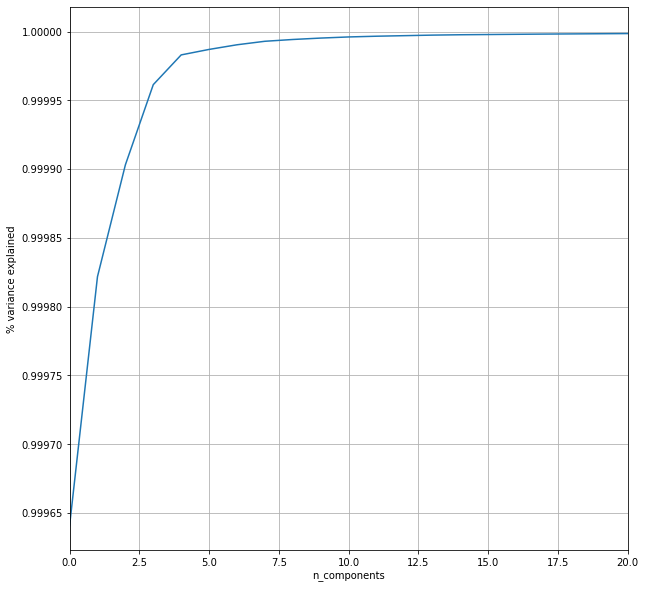

In [ ]:
percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
cumm_var_explained = np.cumsum(percent_var_explained)

plt.figure(figsize=(10,10))
plt.plot(cumm_var_explained)
plt.grid()
plt.xlabel("n_components")

plt.xlim((0,20))

plt.ylabel("% variance explained")
plt.show()

In [ ]:
cumm_var_explained[:53]

array([0.58266975, 0.98450041, 0.99301534, 0.99551208, 0.99694765,
       0.99749482, 0.99794297, 0.99836498, 0.99864558, 0.99886294,
       0.99906676, 0.99926186, 0.99942382, 0.99954483, 0.99962695,
       0.99969347, 0.99975025, 0.99979672, 0.99983611, 0.99986189,
       0.99988489, 0.99990527, 0.99992249, 0.99993854, 0.99995104,
       0.9999619 , 0.99997175, 0.99997817, 0.99998373, 0.99998792,
       0.99999153, 0.99999354, 0.99999495, 0.99999621, 0.99999735,
       0.9999984 , 0.99999914, 0.99999967, 0.99999972, 0.99999977,
       0.99999981, 0.99999985, 0.99999988, 0.9999999 , 0.99999991,
       0.99999992, 0.99999994, 0.99999994, 0.99999995, 0.99999996,
       0.99999997, 0.99999997, 0.99999998])

In [ ]:
vif = calc_vif(df[num_cols])

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1638: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


In [ ]:
pd.set_option('display.max_rows', 200)

In [ ]:
pd.set_option('display.float_format', lambda x: f'%.{len(str(x%1))-2}f' % x)


In [ ]:
vif.sort_values(by='VIF', ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


,variables,VIF
77,EP_UNEMP,inf
106,EPL_UNEMP,inf
99,EP_CROWD,inf
100,MP_CROWD,inf
101,EP_NOVEH,inf
102,MP_NOVEH,inf
103,EP_GROUPQ,inf
104,MP_GROUPQ,inf
105,EPL_POV,inf
107,EPL_PCI,inf


In [ ]:
df.isnull().sum()

date                                                    0
state_fips                                              0
fips                                                    0
index                                                   0
cases_avg                                             547
                                                     ... 
Governor Political Affiliation                          0
State Senate Majority Political Affiliation             0
State House Majority Political Affiliation              0
State Attorney General Political Affiliation            0
State Insurance Commissioner Political Affiliation      0
Length: 169, dtype: int64

In [ ]:
df.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28344 entries, 0 to 1519939
Data columns (total 169 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                28344 non-null  object 
 1   state_fips                                          28344 non-null  object 
 2   fips                                                28344 non-null  object 
 3   index                                               28344 non-null  object 
 4   cases_avg                                           28344 non-null  float64
 5   cases_avg_per_100k                                  28344 non-null  float64
 6   deaths_avg                                          28344 non-null  float64
 7   deaths_avg_per_100k                                 28344 non-null  float64
 8   cases                                               28344 non-null  float

# Keras Time Series Tutorial

In [ ]:
from tensorflow import keras

In [ ]:
from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

13582336/13568290 [==============================] - 0s 0us/step


In [ ]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [ ]:
train_split

300693

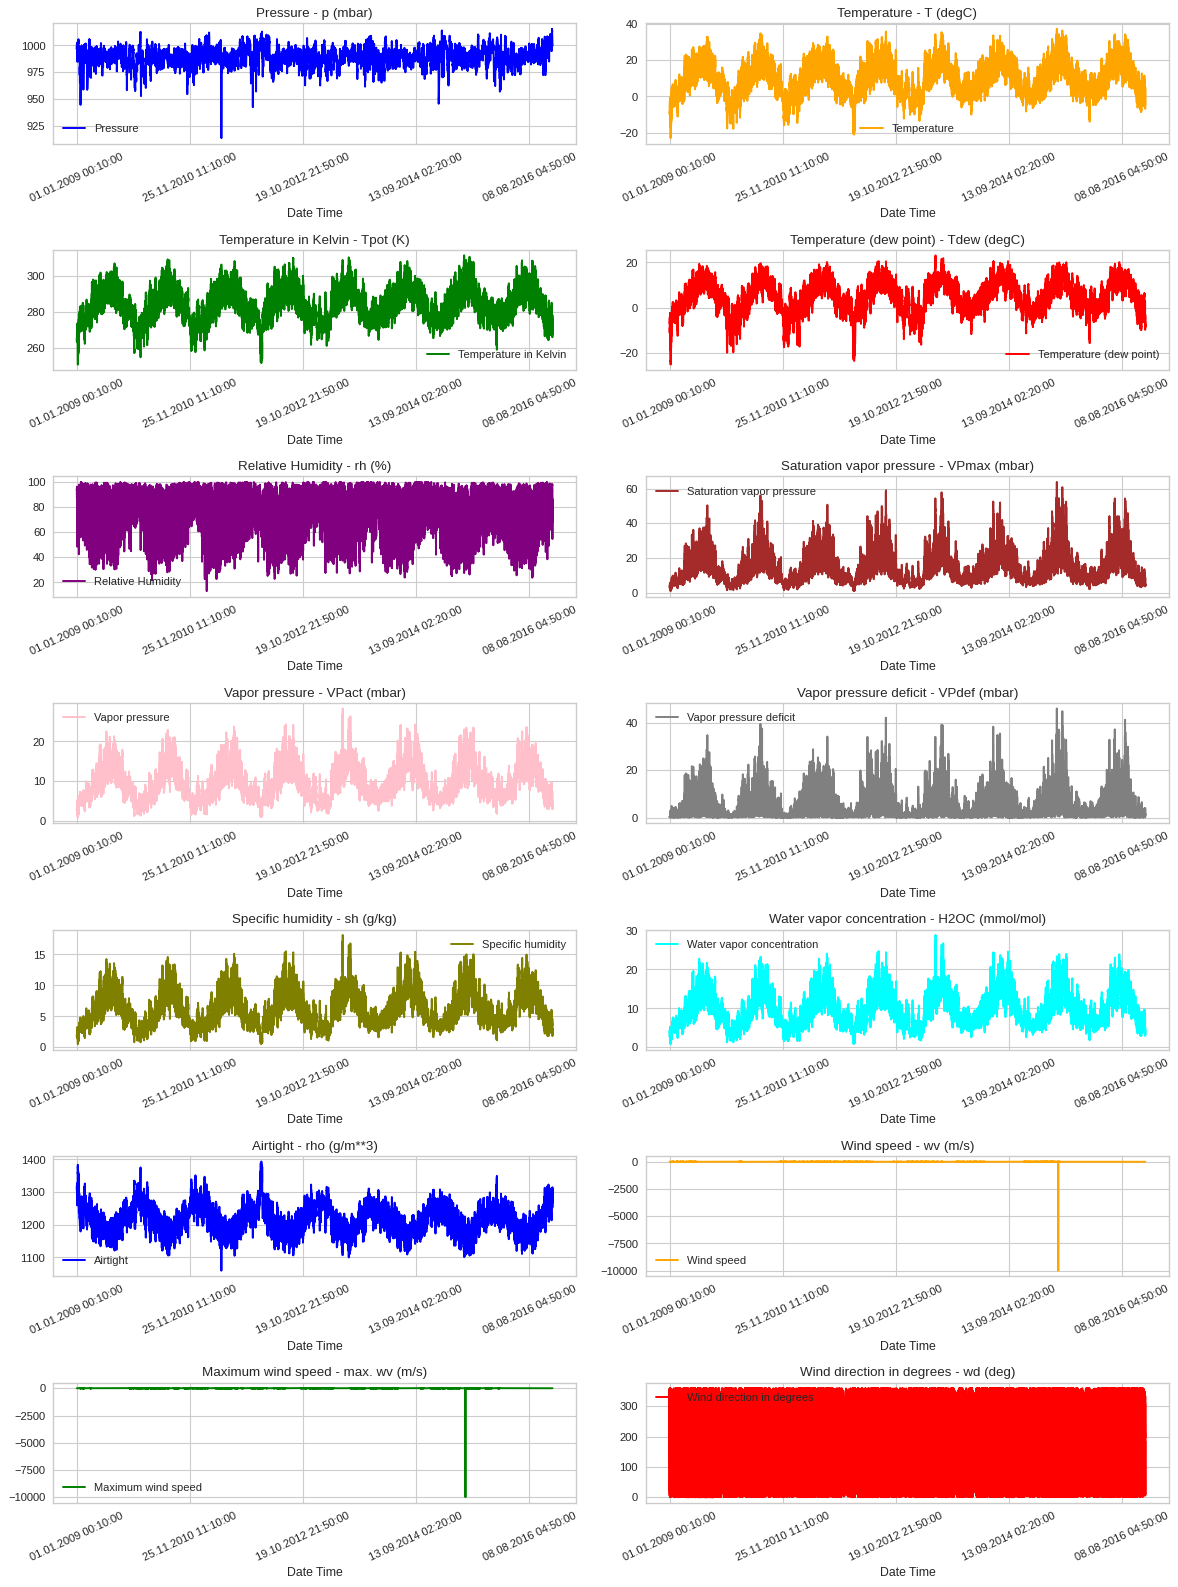

In [ ]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

In [ ]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


In [ ]:
df.shape

(420551, 15)

In [ ]:
display(train_data.shape)
val_data.shape

(300693, 7)

(119858, 7)

In [ ]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

In [ ]:
start

792

In [ ]:
end

301485

In [ ]:
x_train.shape

(300693, 7)

In [ ]:
x_train

array([[ 0.95545114, -2.00002   , -1.31978162, ..., -1.50092673,
         2.23765845, -0.73299722],
       [ 0.96152792, -2.04518494, -1.33280552, ..., -1.51952063,
         2.28783773, -0.93600233],
       [ 0.9566665 , -2.0567657 , -1.3354103 , ..., -1.52323941,
         2.29860792, -1.28307559],
       ...,
       [-0.11163086,  0.90211719,  0.78097422, ...,  1.39228456,
        -0.92045437, -0.79193419],
       [-0.11770764,  0.89632681,  0.77185748, ...,  1.38856578,
        -0.91653794, -0.79193419],
       [-0.11041551,  0.8639007 ,  0.72757621, ...,  1.39600334,
        -0.88740948, -0.8312255 ]])

In [ ]:
y_train

,1
792,-2.745821
793,-2.701814
794,-2.641594
795,-2.597587
796,-2.509573
...,...
301480,0.272124
301481,0.210746
301482,0.264018
301483,0.305708


In [ ]:
sequence_length

120

In [ ]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [ ]:
dataset_train

<BatchDataset shapes: ((None, None, 7), (None, 1)), types: (tf.float64, tf.float64)>

In [ ]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)


Input shape: (256, 120, 7)
Target shape: (256, 1)


In [ ]:
dataset_val

<BatchDataset shapes: ((None, None, 7), (None, 1)), types: (tf.float64, tf.float64)>

In [ ]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 120, 7)]          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                5120      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [ ]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
  73/1172 [>.............................] - ETA: 1:00 - loss: 1.1552

KeyboardInterrupt: ignored

# Loading State Data

In [ ]:
state_df = pd.read_parquet('/content/social_unrest_data/state_social_unrest_10_28.parquet')
state_df.reset_index(inplace=True)
state_df.drop('protest_class', axis=1, inplace=True)
state_df = state_df[state_df.state_fips!=0]
state_df = state_df[state_df.state_fips!=66]
state_df = state_df[state_df.state_fips!=69]
state_df = state_df[state_df.state_fips!=72]
state_df = state_df[state_df.state_fips!=78]
state_df.set_index('date', inplace=True)
state_df = state_df.loc[:'2021-04-15']

# Creating State Regions

In [ ]:
new_england = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island','Vermont']
mideast = ['Delaware', 'DC', 'Maryland', 'New Jersey', 'New York', 'Pennsylvania']
great_lakes = ['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin']
plains = ['Iowa', 'Kansas', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota']
southeast = ['Alabama', 'Arkansas', 'Florida', 'Georgia', 'Kentucky', 'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee', 'Virginia', 'West Virginia']
southwest = ['Arizona', 'New Mexico', 'Oklahoma', 'Texas']
mountain = ['Colorado', 'Idaho', 'Montana', 'Utah', 'Wyoming']
west = ['Alaska', 'California', 'Hawaii', 'Nevada', 'Oregon', 'Washington']
states = []
for state in us.STATES:
  states.append(state.name)
fips = []
for state in us.STATES:
  fips.append(state.fips)
state_fip_dict = dict(zip(states, fips))
state_fip_dict['DC'] = '11'
def convert_fips_region(state_list, state_fip_dict):
  state_fips_list = []
  for state in state_list:
    fips = state_fip_dict[state]
    state_fips_list.append(fips)
  return state_fips_list
new_england_fips = convert_fips_region(new_england, state_fip_dict)
mideast_fips = convert_fips_region(mideast, state_fip_dict)
great_lakes_fips = convert_fips_region(great_lakes, state_fip_dict)
plains_fips = convert_fips_region(plains, state_fip_dict)
southwest_fips = convert_fips_region(southwest, state_fip_dict)
mountain_fips = convert_fips_region(mountain, state_fip_dict)
west_fips = convert_fips_region(west, state_fip_dict)
southeast_fips = convert_fips_region(southeast, state_fip_dict)
def create_fips_region_dict(state_fips, fips_region_dict, region):
  for fips in state_fips:
    fips_region_dict[fips] = region
  return fips_region_dict


fips_region_dict = {}
create_fips_region_dict(new_england_fips, fips_region_dict, 'new_england')
create_fips_region_dict(great_lakes_fips, fips_region_dict, 'great_lakes')
create_fips_region_dict(plains_fips, fips_region_dict, 'plains')
create_fips_region_dict(southwest_fips, fips_region_dict, 'southwest')
create_fips_region_dict(mountain_fips, fips_region_dict, 'mountain')
create_fips_region_dict(west_fips, fips_region_dict, 'west')
create_fips_region_dict(southeast_fips, fips_region_dict, 'southeast')
create_fips_region_dict(mideast_fips, fips_region_dict, 'mideast')
state_df.state_fips = state_df.state_fips.astype(str).str.zfill(2)
state_df['region'] = state_df.state_fips.apply(lambda x: fips_region_dict[x])
state_df.drop('state_fips', axis=1, inplace=True)
region_protest = state_df.groupby([pd.Grouper(freq='D'), 'region'])['binary_protest_class'].sum()
region_protest.rename('protest_binary_count', inplace=True)
region_df = state_df.groupby([pd.Grouper(freq='D'), 'region']).mean()
region_df = pd.concat([region_df, region_protest], axis=1)
region_df.drop('binary_protest_class', axis=1, inplace=True)
region_df.reset_index(inplace=True)
def bin_target(x):
  if x== 0:
    bin = 0
  elif x>0 and x<3:
    bin = 1
  elif x>=3:
    bin = 2
  else:
    bin = 'failed'
  return bin
region_df['target_bins'] = region_df.protest_binary_count.apply(lambda x: bin_target(x))

In [ ]:
region_df.target_bins.value_counts()

1    1715
0    1611
2     351
Name: target_bins, dtype: int64

In [ ]:
fig = px.bar(region_df, x='date', y='target_bins', color='region')
fig.show()

In [ ]:
region_bins = region_df.drop('protest_binary_count', axis=1)

# Pycaret Region

In [ ]:
from pycaret.classification import *

In [ ]:
s = setup(data=region_bins, target='target_bins', train_size=.8, data_split_shuffle=False, fold_strategy='timeseries', fold=2, remove_multicollinearity=True, normalize=True, normalize_method='robust', pca=True)

,Description,Value
0,session_id,2849
1,Target,target_bins
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(3677, 321)"
5,Missing Values,False
6,Numeric Features,316
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
best = compare_models(turbo=True, n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.5153,0.5843,0.4048,0.4997,0.5013,0.1259,0.1279,1.920
et,Extra Trees Classifier,0.5082,0.5924,0.4053,0.4969,0.4979,0.1196,0.1205,0.445
ridge,Ridge Classifier,0.5071,0.0000,0.4162,0.5054,0.5001,0.1397,0.1425,0.620
ada,Ada Boost Classifier,0.4964,0.5677,0.4176,0.5063,0.4892,0.1297,0.1337,0.695
lightgbm,Light Gradient Boosting Machine,0.4923,0.5782,0.4033,0.4971,0.4842,0.1105,0.1137,0.470
gbc,Gradient Boosting Classifier,0.4913,0.5747,0.3980,0.4889,0.4845,0.1070,0.1081,1.515
lr,Logistic Regression,0.4847,0.5846,0.3995,0.4869,0.4810,0.1099,0.1117,2.580
knn,K Neighbors Classifier,0.4811,0.5559,0.3811,0.4655,0.4703,0.0549,0.0553,0.750
rf,Random Forest Classifier,0.4770,0.5772,0.3923,0.4815,0.4693,0.0895,0.0917,1.105
lda,Linear Discriminant Analysis,0.4648,0.5860,0.4424,0.5019,0.4762,0.1291,0.1317,0.015


In [ ]:
plot_model?

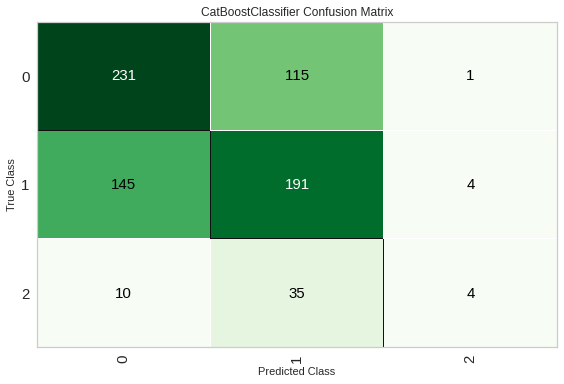

In [ ]:
plot_model(best[0], plot='confusion_matrix')

In [ ]:
predictions = predict_model(best[0])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.5788,0.6606,0.4364,0.5705,0.5655,0.2169,0.2184


In [ ]:
predictions

,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7,Component_8,Component_9,Component_10,Component_11,Component_12,Component_13,Component_14,Component_15,Component_16,Component_17,target_bins,Label,Score
0,-4.489173,-1.145071,-0.767193,-2.982813,1.650090,0.298206,1.481534,-0.751872,0.948408,0.500777,1.095697,-2.278400,-0.125057,-1.483229,-0.599615,-0.827070,-0.603008,0,1,0.7929
1,-4.504101,9.897335,-0.655816,-4.054231,5.332269,-0.774190,4.196378,-0.974279,2.128095,-0.086375,0.260304,-2.730113,1.649508,0.778803,-2.205224,0.443065,-0.018578,1,1,0.7842
2,-4.477506,-3.441191,-0.757475,-1.946292,0.265431,2.113808,0.393635,-1.953040,2.132207,-3.039755,-0.000193,-2.024747,1.511053,0.320060,-1.167003,-0.183399,0.413180,1,0,0.8431
3,-4.486685,2.729801,-0.765343,-3.848984,3.477600,0.838641,0.319498,0.984093,1.434950,2.303605,0.663108,-2.347858,1.554087,-0.227790,-0.361948,-0.828026,0.654230,1,1,0.5162
4,-4.482884,-4.207859,-0.767785,-2.395594,0.619581,2.345466,0.861631,-1.754793,0.801400,-0.423765,0.744164,-2.358887,0.251978,-1.654148,0.362027,0.056836,0.141229,0,0,0.5719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,-4.479894,-0.034140,-0.152926,-3.317448,0.445438,0.921271,-0.604539,2.773627,-1.199924,2.066971,-0.044995,-1.386509,0.582960,-0.108643,-0.169680,0.227078,1.031590,0,0,0.5065
732,-4.469166,-4.414241,-0.091400,-1.785730,-0.833548,2.545865,0.619348,0.046078,-0.168256,-0.741009,0.734325,-1.375870,-0.313048,-0.507588,1.472035,0.674164,0.981387,0,0,0.7763
733,-4.463482,-3.812825,-0.093829,-0.418789,0.090868,-4.427554,3.038125,0.261597,-1.495865,-1.200166,0.934699,-0.629880,0.062483,0.712514,0.898602,0.034402,1.227258,2,0,0.4947
734,-4.427368,-3.561439,-0.108804,1.448375,3.232591,0.763111,-0.529100,1.492826,-2.151904,-0.975891,-0.187027,-0.738723,1.788518,1.609997,0.355469,0.555709,0.312758,0,0,0.7417


In [ ]:
predictions.reset_index(inplace=True)
predictions.Label = predictions.Label.round(0).astype(int)

In [ ]:
predictions['true_rolling_sum_5'] = predictions.target_bins.rolling(15).sum()
predictions['pred_rolling_sum_5'] = predictions.Label.rolling(15).sum()
fig = px.line(predictions, x='date', y=['true_rolling_sum_5', 'pred_rolling_sum_5'], line_group='region', color='region')
fig.show()

# Keras Timeseries, Regions

https://github.com/SeanPLeary/time-series-h2o-automl-example/blob/master/lstm_example_with_multivariate_time_series.ipynb

In [ ]:

from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Model
from keras.layers import Input, Dense
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
from keras.layers import CuDNNLSTM
from sklearn.preprocessing import RobustScaler

In [ ]:
region_df.set_index('date', inplace=True)

In [ ]:
region_df.drop('protest_binary_count', axis=1, inplace=True)

In [ ]:
mideast_df = region_df[region_df.region=='mideast']

In [ ]:
mideast_df.reset_index(inplace=True)
mideast_df.set_index(['region', 'date'], inplace=True)

In [ ]:
mideast_df

cases_avg  cases_avg_per_100k  ...       149  target_bins
region  date                                        ...                       
mideast 2020-01-07    0.000000            0.000000  ... -0.003149            1
        2020-01-08    0.000000            0.000000  ... -0.003149            1
        2020-01-09    0.000000            0.000000  ... -0.003149            1
        2020-01-13   89.010758           21.516655  ... -0.003149            1
        2020-01-14   90.251476           21.752509  ... -0.003149            0
...                        ...                 ...  ...       ...          ...
        2021-04-11  100.723944           24.916155  ... -0.003149            1
        2021-04-12  100.908198           24.966206  ... -0.003149            1
        2021-04-13  101.099326           25.548180  ... -0.003149            0
        2021-04-14  103.766265           26.092127  ... -0.003149            0
        2021-04-15  101.716397           26.056132  ... -0.003149            0

[462 rows x 319 columns]

In [ ]:
split = int(len(mideast_df)*.7)
train = mideast_df[:split]
test = mideast_df[split:]

In [ ]:
x_train = train.drop('target_bins', axis=1)
y_train = train.target_bins
x_test = test.drop('target_bins', axis=1)
y_test = test.target_bins

In [ ]:
x_train

cases_avg  cases_avg_per_100k  ...      148       149
region  date                                        ...                   
mideast 2020-01-07    0.000000            0.000000  ... -0.04092 -0.003149
        2020-01-08    0.000000            0.000000  ... -0.04092 -0.003149
        2020-01-09    0.000000            0.000000  ... -0.04092 -0.003149
        2020-01-13   89.010758           21.516655  ... -0.04092 -0.003149
        2020-01-14   90.251476           21.752509  ... -0.04092 -0.003149
...                        ...                 ...  ...      ...       ...
        2020-11-23  124.443844           35.889065  ... -0.04092 -0.003149
        2020-11-24  122.044078           35.781577  ... -0.04092 -0.003149
        2020-11-25  122.808613           36.380635  ... -0.04092 -0.003149
        2020-11-26  124.669349           37.296205  ... -0.04092 -0.003149
        2020-11-27  127.821024           37.697862  ... -0.04092 -0.003149

[323 rows x 318 columns]

In [ ]:


scaler = RobustScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
train = pd.DataFrame(x_train_scaled)
test = pd.DataFrame(x_test_scaled)
del x_train_scaled
del x_test_scaled

In [ ]:
y_train

region   date      
mideast  2020-01-07    1
         2020-01-08    1
         2020-01-09    1
         2020-01-13    1
         2020-01-14    0
                      ..
         2020-11-23    2
         2020-11-24    1
         2020-11-25    1
         2020-11-26    0
         2020-11-27    1
Name: target_bins, Length: 323, dtype: int64

In [ ]:
train.reset_index(inplace=True)
y_train = pd.DataFrame(y_train).reset_index()
train = pd.concat([train, y_train], axis=1)
#train.set_index(321, inplace=True)

In [ ]:
train.drop('index', axis=1, inplace=True)
train.set_index(['region', 'date'], inplace=True)

In [ ]:
test.reset_index(inplace=True, drop=True)
y_test = pd.DataFrame(y_test).reset_index()
test = pd.concat([test, y_test], ignore_index=True, axis=1)
#test.set_index(321, inplace=True)

In [ ]:
test.set_index([318, 319], inplace=True)

In [ ]:
def generator(dataframe, target_name, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=6):
    
    data = dataframe.values
    #data = data.astype(np.float32)
    target_indx = dataframe.columns.get_loc(target_name)
    
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][target_indx]
        yield samples, targets

In [ ]:
#use previous 450 samples to predict next target ('pollution') samples
lookback = 15 # window used for prediction
delay = 1 # predict target one step ahead
batch_size = 5

train_gen = generator(dataframe = train, 
                      target_name = 'target_bins', 
                      lookback = lookback,
                      delay = 1,
                      min_index = 0,
                      max_index = int(train.shape[0]*0.6),
                      step = 1,
                      shuffle = True,
                      batch_size = batch_size)

In [ ]:
valid_gen = generator(dataframe = train, 
                      target_name = 'target_bins', 
                      lookback = lookback,
                      delay = 1,
                      min_index = int(train.shape[0]*0.6),
                      max_index = None,
                      step = 1,
                      shuffle = False,
                      batch_size = batch_size)


In [ ]:
test_gen = generator(dataframe = test, 
                     target_name = 320, 
                     lookback = lookback,
                     delay = 1,
                     min_index = 0,
                     max_index = None,
                     step = 1,
                     shuffle = False,
                     batch_size = batch_size)

In [ ]:
# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = int((train.shape[0]*.4 - lookback) // batch_size)
print('validation_steps = ', val_steps)
# This is how many steps to draw from `train_gen`
# in order to see the whole train set:
train_steps = int((train.shape[0]*.6 - lookback) // batch_size)
print('train_steps = ', train_steps)
# This is how many steps to draw from `train_gen`
# in order to see the whole train set:
test_steps = int((test.shape[0] - lookback) // batch_size)
print('test_steps = ', test_steps)

validation_steps =  22
train_steps =  35
test_steps =  24


In [ ]:

model = Sequential()
# model.add(LSTM(50,
#                activation='relu',
#                return_sequences=True,
#                stateful=False,
#                input_shape=(None, train.shape[1])))
# model.add(LSTM(50,
#              activation='relu',
#              return_sequences=False,
#              stateful=False))

model.add(CuDNNLSTM(512,
               return_sequences=True,
               stateful=False,
               input_shape=(None, train.shape[1])))
model.add(CuDNNLSTM(250,
               return_sequences=True,
               stateful=False))
model.add(CuDNNLSTM(125,
               return_sequences=True,
               stateful=False))
model.add(CuDNNLSTM(62,
               return_sequences=True,
               stateful=False))
model.add(CuDNNLSTM(30,
               return_sequences=True,
               stateful=False))
model.add(CuDNNLSTM(15,
             return_sequences=False,
             stateful=False))
model.add(Dropout(0.4))

model.add(Dense(3, activation='softmax'))

In [ ]:

callbacks = [EarlyStopping(monitor='val_loss', min_delta = 0, patience=4),ModelCheckpoint(filepath='lstm_model.h5', monitor='val_loss', save_best_only=True)]

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
history = model.fit(train_gen, steps_per_epoch=train_steps, epochs=100, shuffle=False, validation_data=valid_gen,validation_steps=50)

Epoch 1/100


ValueError: ignored

In [ ]:
model.evaluate(test_gen)

  14928/Unknown - 52s 3ms/step - loss: 0.0000e+00 - accuracy: 0.7167

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(test_gen)
#y_pred = model.predict(test_gen,batch_size=256, verbose=1, workers=-1, use_multiprocessing=True)


  68570/Unknown - 533s 8ms/step - loss: 0.1852 - accuracy: 0.7564

KeyboardInterrupt: ignored

In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
test[322].value_counts()

0    451239
1      1035
Name: 322, dtype: int64

In [ ]:
y_truth.sum()

0.0

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_truth, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       256

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



## Keras TimeSeries

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
past = 10
future = 1
learning_rate = 0.001
batch_size = 256
epochs = 10

In [ ]:
start = past + future
end = start + train_split

In [ ]:
end

582527675

## AutoKeras

In [ ]:
predict_from = 1
predict_until = 10
lookback = 3
clf = ak.TimeseriesForecaster(
    lookback=lookback,
    predict_from=predict_from,
    predict_until=predict_until,
    max_trials=1,
    objective="val_loss",
    tuner='random'
)

In [ ]:
clf.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    batch_size=32,
    epochs=10,
)


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
timeseries_bloc...|True              |?                 
timeseries_bloc...|lstm              |?                 
timeseries_bloc...|3                 |?                 
regression_head...|0.25              |?                 
optimizer         |adam              |?                 
learning_rate     |0.01              |?                 

Epoch 1/10


UnknownError: ignored

### Splitting data

In [ ]:
tweets = df.tweets
reddit = df.reddit
articles = df.articles

In [ ]:
df.set_index('date', inplace=True)

In [ ]:
df.drop(['tweets', 'reddit', 'articles'], axis=1, inplace=True)

In [ ]:
float_cols = df.loc[:,'cases_avg': 'Rate_filled' ].columns

In [ ]:
df[float_cols] = df[float_cols].astype(float)

In [ ]:
df['tweets'] = tweets
df['reddit'] = reddit
df['articles'] = articles

In [ ]:
df.info(max_cols=500)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1507578 entries, 2020-01-07 to 2021-05-24
Data columns (total 177 columns):
 #   Column                                                  Non-Null Count    Dtype  
---  ------                                                  --------------    -----  
 0   index                                                   1507578 non-null  int64  
 1   state_fips                                              1507578 non-null  int64  
 2   fips                                                    1507578 non-null  int64  
 3   cases_avg                                               1507578 non-null  float64
 4   cases_avg_per_100k                                      1507578 non-null  float64
 5   deaths_avg                                              1507578 non-null  float64
 6   deaths_avg_per_100k                                     1507578 non-null  float64
 7   cases                                                   1507578 non-null  float64
 

In [ ]:
ca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28344 entries, 0 to 28343
Columns: 1506 entries, level_0 to State Senate Majority Political Affiliation_Unknown
dtypes: datetime64[ns](1), int64(8), object(159), uint8(1338)
memory usage: 72.5+ MB


In [ ]:
ca_embedded = pd.concat([ca, embed_dataframe], axis=1)

In [ ]:
ca_embedded.drop(['level_0', 'index', ''])

In [ ]:
ca_embedded

,level_0,date,index,state_fips,fips,cases_avg,cases_avg_per_100k,deaths_avg,deaths_avg_per_100k,cases,deaths,protest_count,Mobility_score,info_tweets,info_tweets_T,info_tweets_RE,info_tweets_RT,info_tweets_local,info_tweets_verified,info_tweets_unverified,info_fact_reliable,info_fact_unreliable,info_fact_unknown,info_fact_unreliable_fraction,info_fact_shadow,info_fact_missing,info_fact_science,info_fact_msm,info_fact_satire,info_fact_clickbait,info_fact_political,info_fact_fake,info_fact_conspiracy,info_iri,info_iri_T,info_iri_RE,info_iri_RT,info_dyn_iri,info_dyn_iri_RE,info_dyn_iri_RT,...,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,vector_mean
0,0,2020-01-07,0,6,6067,0.0,0.0,0.0,0.0,0.0,0.0,1.0,136.7974131911512,54427.0,12407.0,1770.0,40250.0,45957.0,2614.0,51813.0,9121.0,4737.0,5717.0,0.3418,4729.0,0.0,814.0,8307.0,7.0,32.0,3258.0,1032.0,408.0,0.1328,0.1283,0.0313,0.2012,0.3558,0.2103,0.36,...,-0.088038,-0.10036,0.143893,-0.127874,0.228115,-0.065458,-0.04873,-0.112722,0.051988,-0.14677,0.158444,0.006155,0.011074,0.074389,-0.291783,-0.076755,0.045046,-0.107444,-0.187255,-0.17597,0.093613,0.145429,-0.077466,0.230957,0.137723,-0.061685,-0.303051,0.128833,-0.094219,0.040824,-0.195429,-0.049658,-0.040108,0.185011,-0.095272,-0.246018,-0.036087,0.20382,-0.04092,1.231438
1,68,2020-01-13,68,6,6011,230.7419877422944,18.706395215676263,3.7858451032788856,0.2655708953641225,230.49764601094287,0.0,0.0,100.0,54427.0,12407.0,1770.0,40250.0,45957.0,2614.0,51813.0,9121.0,4737.0,5717.0,0.3418,4729.0,0.0,814.0,8307.0,7.0,32.0,3258.0,1032.0,408.0,0.1328,0.1283,0.0313,0.2012,0.3558,0.2103,0.36,...,-0.088038,-0.10036,0.143893,-0.127874,0.228115,-0.065458,-0.04873,-0.112722,0.051988,-0.14677,0.158444,0.006155,0.011074,0.074389,-0.291783,-0.076755,0.045046,-0.107444,-0.187255,-0.17597,0.093613,0.145429,-0.077466,0.230957,0.137723,-0.061685,-0.303051,0.128833,-0.094219,0.040824,-0.195429,-0.049658,-0.040108,0.185011,-0.095272,-0.246018,-0.036087,0.20382,-0.04092,0.212262
2,69,2020-01-13,69,6,6009,230.7419877422944,18.706395215676263,3.7858451032788856,0.2655708953641225,230.49764601094287,0.0,0.0,100.0,54427.0,12407.0,1770.0,40250.0,45957.0,2614.0,51813.0,9121.0,4737.0,5717.0,0.3418,4729.0,0.0,814.0,8307.0,7.0,32.0,3258.0,1032.0,408.0,0.1328,0.1283,0.0313,0.2012,0.3558,0.2103,0.36,...,-0.088038,-0.10036,0.143893,-0.127874,0.228115,-0.065458,-0.04873,-0.112722,0.051988,-0.14677,0.158444,0.006155,0.011074,0.074389,-0.291783,-0.076755,0.045046,-0.107444,-0.187255,-0.17597,0.093613,0.145429,-0.077466,0.230957,0.137723,-0.061685,-0.303051,0.128833,-0.094219,0.040824,-0.195429,-0.049658,-0.040108,0.185011,-0.095272,-0.246018,-0.036087,0.20382,-0.04092,-0.011138
3,70,2020-01-13,70,6,6007,230.7419877422944,18.706395215676263,3.7858451032788856,0.2655708953641225,230.49764601094287,0.0,0.0,100.0,54427.0,12407.0,1770.0,40250.0,45957.0,2614.0,51813.0,9121.0,4737.0,5717.0,0.3418,4729.0,0.0,814.0,8307.0,7.0,32.0,3258.0,1032.0,408.0,0.1328,0.1283,0.0313,0.2012,0.3558,0.2103,0.36,...,-0.088038,-0.10036,0.143893,-0.127874,0.228115,-0.065458,-0.04873,-0.112722,0.051988,-0.14677,0.158444,0.006155,0.011074,0.074389,-0.291783,-0.076755,0.045046,-0.107444,-0.187255,-0.17597,0.093613,0.145429,-0.077466,0.230957,0.137723,-0.061685,-0.303051,0.128833,-0.094219,0.040824,-0.195429,-0.049658,-0.040108,0.185011,-0.095272,-0.246018,-0.036087,0.20382,-0.04092,0.332095
4,71,2020-01-13,71,6,6005,230.7419877422944,18.706395215676263,3.7858451032788856,0.2655708953641225,230.49764601094287,0.0,0.0,100.0,54427.0,12407.0,1770.0,40250.0,45957.0,2614.0,51813.0,9121.0,4737.0,5717.0,0.3418,4729.0,0.0,814.0,8307.0,7.0,32.0,3258.0,1032.0,408.0,0.1328,0.1283,0.0313,0.2012,0.3558,0.2103,0.36,...,-0.088038,-0.10036,0.143893,-0.127874,0.228115,-0.065458,-0.04873,-0.112722,0.051988,-0.14677,0.158444,0.006155,0.011074,0.074389,-0.291783,-0.076755,0.045046,-0.107444,-0.187255,-0.17597,0.093613,0.145429,-0.077466,0.230957,0.13

In [ ]:
ca_embedded.info(max_cols=2000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28344 entries, 0 to 28343
Data columns (total 232 columns):
 #   Column                                                  Non-Null Count  Dtype         
---  ------                                                  --------------  -----         
 0   level_0                                                 28344 non-null  int64         
 1   date                                                    28344 non-null  datetime64[ns]
 2   index                                                   28344 non-null  int64         
 3   state_fips                                              28344 non-null  int64         
 4   fips                                                    28344 non-null  int64         
 5   cases_avg                                               28344 non-null  object        
 6   cases_avg_per_100k                                      28344 non-null  object        
 7   deaths_avg                                              2

In [ ]:
ca_embedded.drop([''])

## Doc2Vec

In [ ]:
import gensim

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#tokenize and tag the card text
card_docs = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(df.tweets)]


In [ ]:
model = Doc2Vec(vector_size=64, min_count=1, epochs = 10)

In [ ]:
model.build_vocab(card_docs)

In [ ]:
model.train(card_docs, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
card2vec = [model.infer_vector((df['tweets'][i].split(' '))) 
            for i in range(0,len(df['tweets']))]


In [ ]:
card2vec

NameError: ignored

## Getting Numeric Cols

In [ ]:
non_numeric_cols = ['reddit', 'tweets', 'articles', 'Governor Political Affiliation',
       'State Senate Majority Political Affiliation',
       'State House Majority Political Affiliation',
       'State Attorney General Political Affiliation',
       'State Insurance Commissioner Political Affiliation', 'date', 'state_fips', 'index', 'fips', 'ST_ABBR']
num_cols = df.drop(non_numeric_cols, axis=1).columns
df[num_cols] = df[num_cols].apply(pd.to_numeric)

#Pycaret, all us

In [ ]:
from pycaret.regression import *

tcmalloc: large alloc 1189019648 bytes == 0x55dc72a9c000 @  0x7efeb45c6615 0x55d7567a64cc 0x55d75688647a 0x55d7568be793 0x55d7567aa3ce 0x55d7567aa2f9 0x55d756862223 0x55d75685b034 0x55d756749255 0x55d75685c3ac 0x55d75685afda 0x55d75685a8a8 0x55d75685c21b 0x55d75685afda 0x55d756749255 0x55d75685a8a8 0x55d75685c21b 0x55d75685afda 0x55d75685b6a1 0x55d75685c3ac 0x55d75685afda 0x55d75685ad0c 0x55d75685a8a8 0x55d75685a8a8 0x55d756859f3c 0x55d7568f0b2b 0x55d7567a92ed 0x55d75689ae1d 0x55d75681ce99 0x55d7568179ee 0x55d7567aabda
tcmalloc: large alloc 1486274560 bytes == 0x55dcb988c000 @  0x7efeb45c6615 0x55d7567a64cc 0x55d75688647a 0x55d7568be793 0x55d7567aa3ce 0x55d7567aa2f9 0x55d756862223 0x55d75685b034 0x55d756749255 0x55d75685c3ac 0x55d75685afda 0x55d75685a8a8 0x55d75685c21b 0x55d75685afda 0x55d756749255 0x55d75685a8a8 0x55d75685c21b 0x55d75685afda 0x55d75685b6a1 0x55d75685c3ac 0x55d75685afda 0x55d75685acc2 0x55d75685a8a8 0x55d75685a8a8 0x55d756859f3c 0x55d7568f0b2b 0x55d7567a92ed 0x55d75689

In [ ]:
daily_protest_count = state_df.resample('D')['binary_protest_class'].sum()

In [ ]:
daily_protest_count.rename('protest_count', inplace=True)

In [ ]:
all_us = state_df.resample('D').mean()

In [ ]:
all_us = pd.concat([all_us, daily_protest_count],axis=1)

In [ ]:
all_us.fillna(method='pad', inplace=True)

In [ ]:
all_us.drop('binary_protest_class', axis=1, inplace=True)

In [ ]:
s = setup(data=all_us, target='protest_count', train_size=.9, data_split_shuffle=False, fold_strategy='timeseries', fold=3, remove_multicollinearity=True)

,Description,Value
0,session_id,2589
1,Target,protest_count
2,Original Data,"(465, 321)"
3,Missing Values,False
4,Numeric Features,319
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(418, 120)"


In [ ]:
compare_models?

In [ ]:
best = compare_models(turbo=True, n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,3.5812,23.5030,4.7719,-0.0884,0.4995,0.5289,1.5533
br,Bayesian Ridge,4.3342,30.2119,5.3764,-0.3569,0.5568,0.7198,1.8233
huber,Huber Regressor,4.3953,31.4275,5.4431,-0.3624,0.5656,0.7409,1.3167
rf,Random Forest Regressor,4.5848,31.7008,5.4854,-0.3938,0.5904,0.8554,0.7467
lightgbm,Light Gradient Boosting Machine,4.4817,31.7783,5.6004,-0.5300,0.5926,0.7744,0.2267
ada,AdaBoost Regressor,4.7670,36.6136,5.8302,-0.5551,0.6060,0.8625,0.1500
llar,Lasso Least Angle Regression,4.5330,39.2839,5.9072,-0.5587,0.6363,0.5142,4.1167
knn,K Neighbors Regressor,4.4179,35.1138,5.8087,-0.5710,0.7245,0.5679,0.5900
gbr,Gradient Boosting Regressor,4.8131,35.2084,5.8178,-0.5847,0.6021,0.8424,0.1933
xgboost,Extreme Gradient Boosting,5.3260,45.5861,6.3681,-0.8123,0.6504,0.9491,56.0867


In [ ]:
best[0]

In [ ]:
predictions = predict_model(best[0], data=all_us)

In [ ]:
import plotly.express as px

In [ ]:
predictions.reset_index(inplace=True)
predictions.Label = predictions.Label.round(0).astype(int)

In [ ]:
predictions['true_rolling_sum_5'] = predictions.protest_count.rolling(5).sum()
predictions['pred_rolling_sum_5'] = predictions.Label.rolling(5).sum()
fig = px.line(predictions, x='date', y=['true_rolling_sum_5', 'pred_rolling_sum_5'])
fig.show()

In [ ]:
predictions

,date,index,state_fips,cases_avg,cases_avg_per_100k,deaths_avg,deaths_avg_per_100k,cases,deaths,Mobility_score,info_tweets,info_tweets_T,info_tweets_RE,info_tweets_RT,info_tweets_local,info_tweets_verified,info_tweets_unverified,info_fact_reliable,info_fact_unreliable,info_fact_unknown,info_fact_unreliable_fraction,info_fact_shadow,info_fact_missing,info_fact_science,info_fact_msm,info_fact_satire,info_fact_clickbait,info_fact_political,info_fact_fake,info_fact_conspiracy,info_iri,info_iri_T,info_iri_RE,info_iri_RT,info_dyn_iri,info_dyn_iri_RE,info_dyn_iri_RT,reddit_comments_1,reddit_comments_2,reddit_sentiment,...,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,protest_count,Label,true_rolling_sum_5,pred_rolling_sum_5,true_rolling,pred_rolling
0,2020-01-07,0.5,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,136.797413,54427.0,12407.0,1770.0,40250.0,45957.0,2614.0,51813.0,9121.0,4737.0,5717.0,0.3418,4729.0,0.0,814.0,8307.0,7.0,32.0,3258.0,1032.0,408.0,0.1328,0.1283,0.0313,0.2012,0.3558,0.2103,0.3600,0.0,0.0,0.0,...,-0.065458,-0.04873,-0.112722,0.051988,-0.14677,0.158444,0.006155,0.011074,0.074389,-0.291783,-0.076755,0.045046,-0.107444,-0.187255,-0.17597,0.093613,0.145429,-0.077466,0.230957,0.137723,-0.061685,-0.303051,0.128833,-0.094219,0.040824,-0.195429,-0.049658,-0.040108,0.185011,-0.095272,-0.246018,-0.036087,-0.04092,-0.003149,2,2,NaN,NaN,NaN,NaN
1,2020-01-08,2.5,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,136.797413,54427.0,12407.0,1770.0,40250.0,45957.0,2614.0,51813.0,9121.0,4737.0,5717.0,0.3418,4729.0,0.0,814.0,8307.0,7.0,32.0,3258.0,1032.0,408.0,0.1328,0.1283,0.0313,0.2012,0.3558,0.2103,0.3600,0.0,0.0,0.0,...,-0.065458,-0.04873,-0.112722,0.051988,-0.14677,0.158444,0.006155,0.011074,0.074389,-0.291783,-0.076755,0.045046,-0.107444,-0.187255,-0.17597,0.093613,0.145429,-0.077466,0.230957,0.137723,-0.061685,-0.303051,0.128833,-0.094219,0.040824,-0.195429,-0.049658,-0.040108,0.185011,-0.095272,-0.246018,-0.036087,-0.04092,-0.003149,2,2,NaN,NaN,NaN,NaN
2,2020-01-09,4.0,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,136.797413,54427.0,12407.0,1770.0,40250.0,45957.0,2614.0,51813.0,9121.0,4737.0,5717.0,0.3418,4729.0,0.0,814.0,8307.0,7.0,32.0,3258.0,1032.0,408.0,0.1328,0.1283,0.0313,0.2012,0.3558,0.2103,0.3600,0.0,0.0,0.0,...,-0.065458,-0.04873,-0.112722,0.051988,-0.14677,0.158444,0.006155,0.011074,0.074389,-0.291783,-0.076755,0.045046,-0.107444,-0.187255,-0.17597,0.093613,0.145429,-0.077466,0.230957,0.137723,-0.061685,-0.303051,0.128833,-0.094219,0.040824,-0.195429,-0.049658,-0.040108,0.185011,-0.095272,-0.246018,-0.036087,-0.04092,-0.003149,1,0,NaN,NaN,NaN,NaN
3,2020-01-10,4.0,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,136.797413,54427.0,12407.0,1770.0,40250.0,45957.0,2614.0,51813.0,9121.0,4737.0,5717.0,0.3418,4729.0,0.0,814.0,8307.0,7.0,32.0,3258.0,1032.0,408.0,0.1328,0.1283,0.0313,0.2012,0.3558,0.2103,0.3600,0.0,0.0,0.0,...,-0.065458,-0.04873,-0.112722,0.051988,-0.14677,0.158444,0.006155,0.011074,0.074389,-0.291783,-0.076755,0.045046,-0.107444,-0.187255,-0.17597,0.093613,0.145429,-0.077466,0.230957,0.137723,-0.061685,-0.303051,0.128833,-0.094219,0.040824,-0.195429,-0.049658,-0.040108,0.185011,-0.095272,-0.246018,-0.036087,-0.04092,-0.003149,0,0,NaN,NaN,NaN,NaN
4,2020-01-11,4.0,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,136.797413,54427.0,12407.0,1770.0,40250.0,45957.0,2614.0,51813.0,9121.0,4737.0,5717.0,0.3418,4729.0,0.0,814.0,8307.0,7.0,32.0,3258.0,1032.0,408.0,0.1328,0.1283,0.0313,0.2012,0.3558,0.2103,0.3600,0.0,0.0,0.0,...,-0.065458,-0.04873,-0.112722,0.051988,-0.14677,0.158444,0.006155,0.011074,0.074389,-0.291783,-0.076755,0.045046,-0.107444,-0.187255,-0.17597,0.093613,0.145429,-0.077466,0.230957,0.137723,-0.061685,-0.303051,0.128833,-0.094219,0.040824,-0.195429,-0.049658,-0.040108,0.185011,-0.095272,-0.246018,-0.036087,-0.04092,-0.003149,0,

In [ ]:
predictions['true_rolling'] = predictions.protest_count.rolling(10).sum()
predictions['pred_rolling'] = predictions.Label.rolling(10).sum()
fig = px.line(predictions, x='date', y=['true_rolling', 'pred_rolling'])
fig.show()

In [ ]:
predictions['true_rolling'] = predictions.protest_count.rolling(5).mean()
predictions['pred_rolling'] = predictions.Label.rolling(5).mean()
predictions['true_rolling'] = predictions['true_rolling'].round(1)
predictions['pred_rolling'] = predictions['pred_rolling'].round(1)
fig = px.line(predictions, x='date', y=['true_rolling', 'pred_rolling'])
fig.show()

# TSFRESH

In [ ]:
from tsfresh import extract_features
from tsfresh.utilities.distribution import MultiprocessingDistributor

In [ ]:
Distributor = MultiprocessingDistributor(n_workers=8,
                                         disable_progressbar=False,
                                         progressbar_title="Feature Extraction")

In [ ]:
all_us.protest_count.sum()

3534

In [ ]:
y = all_us.protest_count
features = all_us.drop('protest_count', axis=1)

In [ ]:
features

,date,state_fips,cases_avg,cases_avg_per_100k,deaths_avg,deaths_avg_per_100k,cases,deaths,Mobility_score,info_tweets,info_tweets_T,info_tweets_RE,info_tweets_RT,info_tweets_local,info_tweets_verified,info_tweets_unverified,info_fact_reliable,info_fact_unreliable,info_fact_unknown,info_fact_unreliable_fraction,info_fact_shadow,info_fact_missing,info_fact_science,info_fact_msm,info_fact_satire,info_fact_clickbait,info_fact_political,info_fact_fake,info_fact_conspiracy,info_iri,info_iri_T,info_iri_RE,info_iri_RT,info_dyn_iri,info_dyn_iri_RE,info_dyn_iri_RT,reddit_comments_1,reddit_comments_2,reddit_sentiment,AREA_SQMI,...,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149
0,2020-01-07,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,136.797413,54427.0,12407.0,1770.0,40250.0,45957.0,2614.0,51813.0,9121.0,4737.0,5717.0,0.3418,4729.0,0.0,814.0,8307.0,7.0,32.0,3258.0,1032.0,408.0,0.1328,0.1283,0.0313,0.2012,0.3558,0.2103,0.3600,0.0,0.0,0.0,796.903096,...,0.073455,-0.088038,-0.10036,0.143893,-0.127874,0.228115,-0.065458,-0.04873,-0.112722,0.051988,-0.14677,0.158444,0.006155,0.011074,0.074389,-0.291783,-0.076755,0.045046,-0.107444,-0.187255,-0.17597,0.093613,0.145429,-0.077466,0.230957,0.137723,-0.061685,-0.303051,0.128833,-0.094219,0.040824,-0.195429,-0.049658,-0.040108,0.185011,-0.095272,-0.246018,-0.036087,-0.04092,-0.003149
1,2020-01-08,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,136.797413,54427.0,12407.0,1770.0,40250.0,45957.0,2614.0,51813.0,9121.0,4737.0,5717.0,0.3418,4729.0,0.0,814.0,8307.0,7.0,32.0,3258.0,1032.0,408.0,0.1328,0.1283,0.0313,0.2012,0.3558,0.2103,0.3600,0.0,0.0,0.0,338.060387,...,0.073455,-0.088038,-0.10036,0.143893,-0.127874,0.228115,-0.065458,-0.04873,-0.112722,0.051988,-0.14677,0.158444,0.006155,0.011074,0.074389,-0.291783,-0.076755,0.045046,-0.107444,-0.187255,-0.17597,0.093613,0.145429,-0.077466,0.230957,0.137723,-0.061685,-0.303051,0.128833,-0.094219,0.040824,-0.195429,-0.049658,-0.040108,0.185011,-0.095272,-0.246018,-0.036087,-0.04092,-0.003149
2,2020-01-09,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,136.797413,54427.0,12407.0,1770.0,40250.0,45957.0,2614.0,51813.0,9121.0,4737.0,5717.0,0.3418,4729.0,0.0,814.0,8307.0,7.0,32.0,3258.0,1032.0,408.0,0.1328,0.1283,0.0313,0.2012,0.3558,0.2103,0.3600,0.0,0.0,0.0,224.433917,...,0.073455,-0.088038,-0.10036,0.143893,-0.127874,0.228115,-0.065458,-0.04873,-0.112722,0.051988,-0.14677,0.158444,0.006155,0.011074,0.074389,-0.291783,-0.076755,0.045046,-0.107444,-0.187255,-0.17597,0.093613,0.145429,-0.077466,0.230957,0.137723,-0.061685,-0.303051,0.128833,-0.094219,0.040824,-0.195429,-0.049658,-0.040108,0.185011,-0.095272,-0.246018,-0.036087,-0.04092,-0.003149
3,2020-01-10,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,136.797413,54427.0,12407.0,1770.0,40250.0,45957.0,2614.0,51813.0,9121.0,4737.0,5717.0,0.3418,4729.0,0.0,814.0,8307.0,7.0,32.0,3258.0,1032.0,408.0,0.1328,0.1283,0.0313,0.2012,0.3558,0.2103,0.3600,0.0,0.0,0.0,224.433917,...,0.073455,-0.088038,-0.10036,0.143893,-0.127874,0.228115,-0.065458,-0.04873,-0.112722,0.051988,-0.14677,0.158444,0.006155,0.011074,0.074389,-0.291783,-0.076755,0.045046,-0.107444,-0.187255,-0.17597,0.093613,0.145429,-0.077466,0.230957,0.137723,-0.061685,-0.303051,0.128833,-0.094219,0.040824,-0.195429,-0.049658,-0.040108,0.185011,-0.095272,-0.246018,-0.036087,-0.04092,-0.003149
4,2020-01-11,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,136.797413,54427.0,12407.0,1770.0,40250.0,45957.0,2614.0,51813.0,9121.0,4737.0,5717.0,0.3418,4729.0,0.0,814.0,8307.0,7.0,32.0,3258.0,1032.0,408.0,0.1328,0.1283,0.0313,0.2012,0.3558,0.2103,0.3600,0.0,0.0,0.0,224.433917,...,0.073455,-0.088038,-0.10036,0.143893,-0.127874,0.228115,-0.065458,-0.04873,-0.112722,0.051988,-0.14677,0.158444,0.006155,0.011074,0.074389,-0.291783,-0.076755,0.045046,-0.107444,-0.187255,-0.17597,0.093

In [ ]:
features.drop('index', axis=1, inplace=True)

In [ ]:
features.reset_index(inplace=True)

In [ ]:
features['id'] = 1

In [ ]:
from tsfresh.utilities.dataframe_functions import roll_time_series
df_rolled = roll_time_series(features, column_id="id", column_sort="date")

Rolling: 100%|██████████| 39/39 [00:11<00:00,  3.29it/s]


In [ ]:
from tsfresh import extract_features
df_features = extract_features(df_rolled, column_id="id", column_sort="date")

Feature Extraction: 100%|██████████| 40/40 [40:55<00:00, 61.39s/it]


In [ ]:
df_features

state_fips__variance_larger_than_standard_deviation  ...  149__matrix_profile__feature_"75"__threshold_0.98
1 2020-01-07                                                0.0    ...                                                NaN
  2020-01-08                                                0.0    ...                                                NaN
  2020-01-09                                                1.0    ...                                                NaN
  2020-01-10                                                1.0    ...                                                NaN
  2020-01-11                                                1.0    ...                                                NaN
...                                                         ...    ...                                                ...
  2021-04-11                                                0.0    ...                                                NaN
  2021-04-12                                                0.0    ...                                                NaN
  2021-04-13                                                0.0    ...                                                NaN
  2021-04-14                                                0.0    ...                                                NaN
  2021-04-15                                                0.0    ...                                                NaN

[465 rows x 251053 columns]

# Keras Regions

In [ ]:
region_df.reset_index(inplace=True)
west = region_df[region_df.region=='west']

In [ ]:
west.set_index(['region', 'date'], inplace=True)

In [ ]:
#train test split

split = int(len(west)*.7)
train = west[:split]
test = west[split:]

x_train = train.drop('target_bins', axis=1)
y_train = train['target_bins']
x_test = test.drop('target_bins', axis=1)
y_test = test['target_bins']


from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)



In [ ]:
x_train_scaled.shape

(322, 318)

In [ ]:
y_train.shape

(322,)

In [ ]:
x_test_scaled.shape

(138, 318)

In [ ]:
y_test.shape

(138,)

In [ ]:
y_train

region  date      
west    2020-01-07    1
        2020-01-13    0
        2020-01-14    0
        2020-01-15    0
        2020-01-16    0
                     ..
        2020-11-24    1
        2020-11-25    1
        2020-11-26    1
        2020-11-27    1
        2020-11-28    1
Name: target_bins, Length: 322, dtype: int64

In [ ]:
y_train_cat = tf.keras.utils.to_categorical(y_train, 3)
y_test_cat = tf.keras.utils.to_categorical(y_test, 3)

In [ ]:
split_fraction = 0.7
train_split = int(split_fraction * int(west.shape[0]))
step = 2

past = 20
future = 5
learning_rate = 0.001
batch_size = 10
epochs = 200

start = past + future
end = start + train_split



sequence_length = int(past / step)

In [ ]:
dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train_scaled,
    y_train_cat,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [ ]:
for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (10, 10, 318)
Target shape: (10, 3)


In [ ]:
dataset_test = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_test_scaled,
    y_test_cat,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [ ]:
for batch in dataset_test.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (10, 10, 318)
Target shape: (10, 3)


In [ ]:
# inputs = tf.keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
# lstm_out = tf.keras.layers.LSTM(32)(inputs)
# outputs = tf.keras.layers.Dense(3, activation='softmax')(lstm_out)

# model = tf.keras.Model(inputs=inputs, outputs=outputs)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=['accuracy'])
# model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 15, 318)]         0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                44928     
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 99        
Total params: 45,027
Trainable params: 45,027
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = Sequential()
# model.add(LSTM(50,
#                activation='relu',
#                return_sequences=True,
#                stateful=False,
#                input_shape=(None, train.shape[1])))
# model.add(LSTM(50,
#              activation='relu',
#              return_sequences=False,
#              stateful=False))

model.add(CuDNNLSTM(512,
               return_sequences=True,
               stateful=False,
               input_shape=(None, x_train_scaled.shape[1])))
model.add(Dropout(0.1))
model.add(CuDNNLSTM(250,
               return_sequences=True,
               stateful=False))
model.add(Dropout(0.1))
model.add(CuDNNLSTM(125,
               return_sequences=True,
               stateful=False))
model.add(Dropout(0.1))
model.add(CuDNNLSTM(62,
               return_sequences=True,
               stateful=False))
model.add(Dropout(0.1))
model.add(CuDNNLSTM(30,
               return_sequences=True,
               stateful=False))
model.add(Dropout(0.1))
model.add(CuDNNLSTM(15,
             return_sequences=False,
             stateful=False))
model.add(Dropout(0.1))

model.add(Dense(3, activation='sigmoid'))

In [ ]:
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
      #keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [ ]:
class_weights

array([1.2627451 , 0.52873563, 3.15686275])

In [ ]:
#model = tf.keras.model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=METRICS)
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_78 (CuDNNLSTM)    (None, None, 512)         1703936   
_________________________________________________________________
dropout_23 (Dropout)         (None, None, 512)         0         
_________________________________________________________________
cu_dnnlstm_79 (CuDNNLSTM)    (None, None, 250)         764000    
_________________________________________________________________
dropout_24 (Dropout)         (None, None, 250)         0         
_________________________________________________________________
cu_dnnlstm_80 (CuDNNLSTM)    (None, None, 125)         188500    
_________________________________________________________________
dropout_25 (Dropout)         (None, None, 125)         0         
_________________________________________________________________
cu_dnnlstm_81 (CuDNNLSTM)    (None, None, 62)        

In [ ]:

# callbacks = [EarlyStopping(monitor='val_loss', min_delta = 0, patience=4),ModelCheckpoint(filepath='lstm_model.h5', monitor='val_loss', save_best_only=True)]

# model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
# history = model.fit(train_gen, steps_per_epoch=train_steps, epochs=100, shuffle=False, validation_data=valid_gen,validation_steps=50)

In [ ]:
path_checkpoint = "model_checkpoint.h5"
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)
callbacks=[es_callback, modelckpt_callback],

modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    shuffle=False,
    validation_data=dataset_test
    
)

Epoch 1/200
31/31 [==============================] - 5s 50ms/step - loss: 0.9105 - fn: 65.0000 - accuracy: 0.6139 - precision: 0.5409 - recall: 0.7855 - auc: 0.7695 - val_loss: 0.8134 - val_fn: 32.0000 - val_accuracy: 0.7311 - val_precision: 0.7311 - val_recall: 0.7311 - val_auc: 0.7579
Epoch 2/200
31/31 [==============================] - 0s 15ms/step - loss: 0.9438 - fn: 90.0000 - accuracy: 0.6172 - precision: 0.5246 - recall: 0.7030 - auc: 0.7553 - val_loss: 0.8949 - val_fn: 27.0000 - val_accuracy: 0.7311 - val_precision: 0.4868 - val_recall: 0.7731 - val_auc: 0.7664
Epoch 3/200
31/31 [==============================] - 0s 16ms/step - loss: 0.8521 - fn: 45.0000 - accuracy: 0.5908 - precision: 0.5536 - recall: 0.8515 - auc: 0.7794 - val_loss: 0.9565 - val_fn: 26.0000 - val_accuracy: 0.7311 - val_precision: 0.4794 - val_recall: 0.7815 - val_auc: 0.7713
Epoch 4/200
31/31 [==============================] - 0s 16ms/step - loss: 0.8158 - fn: 47.0000 - accuracy: 0.5941 - precision: 0.5766 - 